In the notebook "[Cleaning the data for rapid prototyping](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai)" I showed how to create a small, fast, ready-to-use dataset for prototyping our models. The dataset created in that notebook, along with the metadata files it uses, are now [available here](https://www.kaggle.com/jhoward/rsna-hemorrhage-jpg).

So let's use them to create a model! In this notebook we'll see the whole journey from pre-training using progressive resizing on our prototyping sample, through to fine-tuning on the full dataset, and then submitting to the competition.

In my testing overnight with this notebook on my local machine I was seeing scores that would land towards the top of the leaderboard with a single model, with just some minor tweaking. I'm intentionally not doing any tricky modeling in this notebook, because I want to show the power of simple techniques and simples architectures. You should take this as a starting point and experiment! e.g. try data augmentation methods, architectures, preprocessing approaches, using the DICOM metadata, and so forth...

We'll be using the fastai.medical.imaging library here - for more information about this see the notebook [Some DICOM gotchas to be aware of](https://www.kaggle.com/jhoward/some-dicom-gotchas-to-be-aware-of-fastai). We'll also use the same basic setup that's in the notebook.

I've used up my GPU hours for the week, so I've commented out all the cells that use GPU. I'll run them tomorrow and update the notebook then.

In [1]:
# !pip install torch torchvision feather-format kornia pyarrow --upgrade   > /dev/null
# !pip install git+https://github.com/fastai/fastai_dev@2e45c62dcc84ee2d4f38c1be80b54b9855c29f64'
# !pip install git+https://github.com/fastai/fastai_dev > /dev/null

In [2]:
from fastai2.basics           import *
from fastai2.vision.all       import *
from fastai2.medical.imaging  import *
from fastai2.callback.tracker import *

np.set_printoptions(linewidth=120)
matplotlib.rcParams['image.cmap'] = 'bone'

In [3]:
! ls ~/rsna_data

stage_1_sample_submission.csv  stage_1_train.csv
stage_1_test_images	       stage_1_train_images


In [6]:
ls models

dcm-192-bs64ep1,3.pth                dcm-512-bs32ep1,2.pth
dcm-256-bs64ep2,3.pth                initial-160-bs128ep1,4.pth
dcm-384-bs64--ep3.pth                initial-256-bs128ep2,5.pth
dcm-384-bs64--ep4.pth                initial-96-bs128ep1,3.pth
dcm-384-bs64-ShortEpoch0pt2-2,2.pth


First we read in the metadata files (linked in the introduction).

In [7]:
path = Path('/home/tirrell_le/rsna_data/')
path_trn = path/'stage_1_train_images'
path_tst = path/'stage_1_test_images'

path_inp = Path('/home/tirrell_le/jhoward_data')
path_xtra = path_inp
path_meta = path_xtra/'meta'/'meta'
path_jpg = path_xtra/'train_jpg'/'train_jpg'

In [8]:
df_comb = pd.read_feather(path_meta/'comb.fth').set_index('SOPInstanceUID')
df_tst  = pd.read_feather(path_meta/'df_tst.fth').set_index('SOPInstanceUID')
df_samp = pd.read_feather(path_meta/'wgt_sample.fth').set_index('SOPInstanceUID')
bins = (path_meta/'bins.pkl').load()

## Train vs valid

To get better validation measures, we should split on patients, not just on studies, since that's how the test set is created.

Here's a list of random patients:

In [9]:
set_seed(42)
patients = df_comb.PatientID.unique()
pat_mask = np.random.random(len(patients))<0.8
pat_trn = patients[pat_mask]

We can use that to take just the patients in a dataframe that match that mask:

In [10]:
def split_data(df):
    idx = L.range(df)
    mask = df.PatientID.isin(pat_trn)
    return idx[mask],idx[~mask]

splits = split_data(df_samp)

Let's double-check that for a patient in the training set that their images are all in the first split.

In [11]:
df_trn = df_samp.iloc[splits[0]]
p1 = L.range(df_samp)[df_samp.PatientID==df_trn.PatientID[0]]
assert len(p1) == len(set(p1) & set(splits[0]))

## Prepare sample DataBunch

We will grab our sample filenames for the initial pretraining.

In [12]:
def filename(o): return os.path.splitext(os.path.basename(o))[0]

fns = L(list(df_samp.fname)).map(filename)
fn = fns[0]
fn

'ID_2a8702d25'

We need to create a `DataBunch` that contains our sample data, so we need a function to convert a filename (pointing at a DICOM file) into a path to our sample JPEG files:

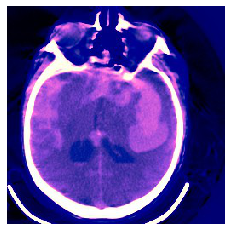

In [13]:
def fn2image(fn): return PILCTScan.create((path_jpg/fn).with_suffix('.jpg'))
fn2image(fn).show();

We also need to be able to grab the labels from this, which we can do by simply indexing into our sample `DataFrame`.

In [14]:
htypes = ['any','epidural','intraparenchymal','intraventricular','subarachnoid','subdural']
def fn2label(fn): return df_comb.loc[fn][htypes].values.astype(np.float32)
fn2label(fn)

array([1., 0., 1., 1., 0., 0.], dtype=float32)

If you have a larger GPU or more workers, change batchsize and number-of-workers here:

In [15]:
bs,nw = 128,8

We're going to use fastai's new [Transform Pipeline API](http://dev.fast.ai/pets.tutorial.html) to create the DataBunch, since this is extremely flexible, which is great for intermediate and advanced Kagglers. (Beginners will probably want to stick with the Data Blocks API). We create two transform pipelines, one to open the image file, and one to look up the label and create a tensor of categories.

In [16]:
torch.cuda.is_available()

True

In [17]:
tfms = [[fn2image], [fn2label,EncodedMultiCategorize(htypes)]]
dsrc = DataSource(fns, tfms, splits=splits)
nrm = Normalize(tensor([0.6]),tensor([0.25]))
aug = aug_transforms(p_lighting=0.)
batch_tfms = [IntToFloatTensor(), nrm, Cuda(), *aug]

To support progressive resizing (one of the most useful tricks in the deep learning practitioner's toolbox!) we create a function that returns a dataset resized to a requested size:

In [18]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_item=[ToTensor],
                          after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

Let's try it out!

(tensor(-0.7605), tensor(1.4003), torch.Size([128, 3, 96, 96]), 902)

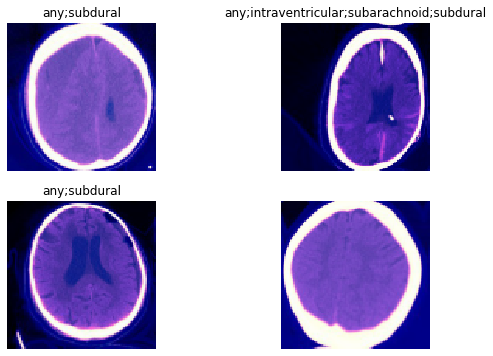

In [19]:
dbch = get_data(128, 96)
xb,yb = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4, figsize=(9,6))
xb.mean(),xb.std(),xb.shape,len(dbch.train_dl)

Let's track the accuracy of the *any* label as our main metric, since it's easy to interpret.

In [20]:
def accuracy_any(inp, targ, thresh=0.5, sigmoid=True):
    inp,targ = flatten_check(inp[:,0],targ[:,0])
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

The loss function in this competition is weighted, so let's train using that loss function too.

In [21]:
def get_loss(scale=1.0):
    loss_weights = tensor(2.0, 1, 1, 1, 1, 1).cuda()*scale
    return BaseLoss(nn.BCEWithLogitsLoss, pos_weight=loss_weights, floatify=True, flatten=False, 
        is_2d=False, activation=torch.sigmoid)

loss_func = get_loss(0.14*2)  #scaled due to resampling
opt_func = partial(Adam, wd=0.01, eps=1e-3)
metrics=[accuracy_multi,accuracy_any]

Now we're ready to create our learner. We can use mixed precision (fp16) by simply adding a call to `to_fp16()`!

In [22]:
def get_learner():
    dbch = get_data(128,128)
    learn = cnn_learner(dbch, resnet101, loss_func=loss_func, opt_func=opt_func, metrics=metrics)
    return learn.to_fp16()

In [23]:
learn = get_learner()

Leslie Smith's famous LR finder will give us a reasonable learning rate suggestion.

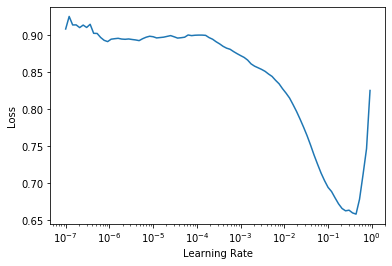

In [20]:
lrf = learn.lr_find()

## Pretrain on sample

Here's our main routine for changing the size of the images in our DataBunch, doing one fine-tuning of the final layers, and then training the whole model for a few epochs.

In [24]:
cbs = []
def do_fit(bs,sz,epochs,lr, freeze=True,epochs_frozen=1):
    learn.dbunch = get_data(bs, sz)
    if freeze:
        if learn.opt is not None: learn.opt.clear_state()
        learn.freeze()
        learn.fit_one_cycle(epochs_frozen, slice(lr), cbs=cbs)
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr), cbs=cbs)

Now we can train at 3 different sizes.

In [28]:
do_fit(128, 96, 3, 2e-2)
learn.save('initial-96-bs128ep1,3')
lrf

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.160478,0.158177,0.848304,0.832894,04:15


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.171410,0.167413,0.839904,0.827891,05:44
1,0.130831,0.131442,0.878306,0.872586,05:44
2,0.118671,0.123208,0.884732,0.875655,05:44


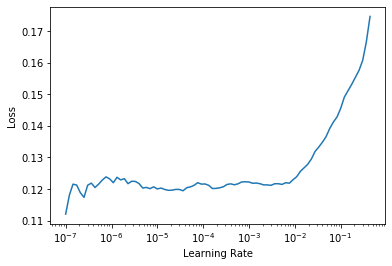

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.125147,0.127578,0.877283,0.866982,07:15


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.118497,0.117776,0.890436,0.886528,09:56
1,0.112908,0.113925,0.894850,0.891064,09:55
2,0.108671,0.112145,0.897335,0.895034,09:55
3,0.106769,0.112233,0.896651,0.894133,09:55


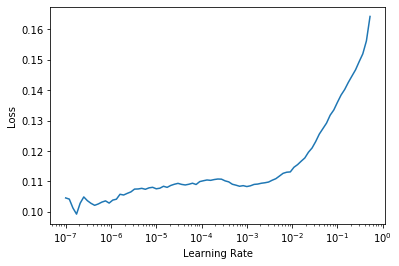

In [32]:
do_fit(128, 160, 4, 1e-3)
learn.save('initial-160-bs128ep1,4')
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.119475,0.124132,0.884038,0.877256,14:33
1,0.116053,0.122949,0.887518,0.882959,14:27


epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.114025,0.116373,0.893699,0.887495,19:51
1,0.108101,0.110318,0.899464,0.897869,19:49
2,0.104268,0.107459,0.902383,0.902538,19:49
3,0.099342,0.106265,0.905613,0.905907,19:49
4,0.099890,0.106946,0.905557,0.907008,19:50


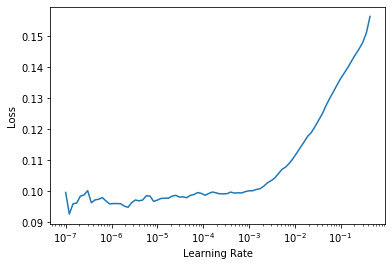

In [35]:
do_fit(128, 256, 5, 1e-3, epochs_frozen=2)
learn.save('initial-256-bs128ep2,5')
learn.lr_find()

## Scale up to full dataset

Now let's fine tune this model on the full dataset. We'll need all the filenames now, not just the sample.

In [25]:
fns = L(list(df_comb.fname)).map(filename)
splits = split_data(df_comb)  # use full dataset

These functions are copied nearly verbatim from our [earlier cleanup notebook](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai), so have a look there for details.

In [26]:
def fix_pxrepr(dcm):
    if dcm.PixelRepresentation != 0 or dcm.RescaleIntercept<-100: return
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

In [27]:
def dcm_tfm(fn): 
    fn = (path_trn/fn).with_suffix('.dcm')
    try:
        x = fn.dcmread()
        fix_pxrepr(x)
    except Exception as e:
        print(fn,e)
        raise SkipItemException
    if x.Rows != 512 or x.Columns != 512: x.zoom_to((512,512))
    px = x.scaled_px
    return TensorImage(px.to_3chan(dicom_windows.brain,dicom_windows.subdural, bins=bins))

torch.Size([3, 512, 512])

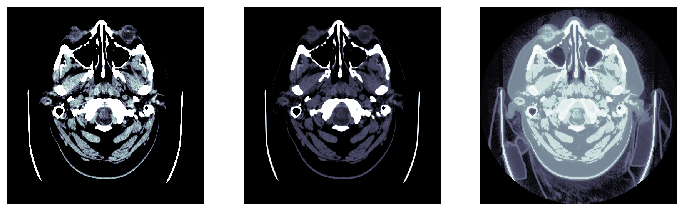

In [28]:
dcm = dcm_tfm(fns[0])
show_images(dcm)
dcm.shape

We have some slight changes to our data source

In [29]:
tfms = [[dcm_tfm], [fn2label,EncodedMultiCategorize(htypes)]]
dsrc = DataSource(fns, tfms, splits=splits)
batch_tfms = [nrm, Cuda(), *aug]

In [30]:
def get_data(bs, sz):
    return dsrc.databunch(bs=bs, num_workers=nw, after_batch=batch_tfms+[AffineCoordTfm(size=sz)])

Now we can test it out:

torch.Size([64, 3, 256, 256])

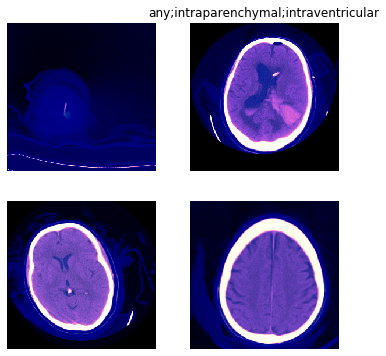

In [31]:
dbch = get_data(64,256)
x,y = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4)
x.shape

In [32]:
# remove sample scaling
learn.loss_func = get_loss(1.0)

For fine-tuning the final layers, we don't really need to use a whole epoch, so we'll use the `ShortEpochCallback` to just train for 10% of an epoch, before then unfreezing the model and training a bit more.

In [33]:
def fit_tune(bs, sz, epochs, lr, freeze=True,epochs_frozen=1):
    dbch = get_data(bs, sz)
    learn.dbunch = dbch
    learn.opt.clear_state()
    if freeze:
        learn.freeze()
        learn.fit_one_cycle(epochs_frozen, slice(lr), cbs=ShortEpochCallback(pct=0.2))
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))

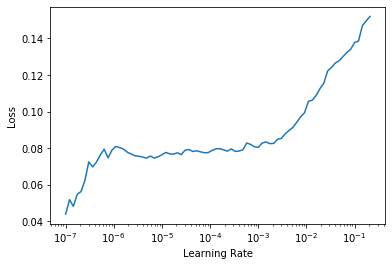

In [45]:
fit_tune(64, 192, 3, (1e-3/3))
learn.save('dcm-192-bs64ep1,3')
learn.lr_find()

In [ ]:
fit_tune(64, 256, 3, 3e-4, epochs_frozen=2)
learn.save('dcm-256-bs64ep2,3')
learn.lr_find()

In [59]:
# import gc; gc.collect()
# torch.cuda.empty_cache()

In [34]:
#@# ran this to create dcm-384-bs64-ShortEpoch0pt2-2,2.pth, seems to do the wrong thing                                           
#   (short epochs on all runs)                                                                                                    
def fit_tune2(bs, sz, epochs, lr, freeze=True,epochs_frozen=1):
    dbch = get_data(bs, sz)
    learn.dbunch = dbch

    if freeze:
        learn.opt.clear_state()
        learn.freeze()
        learn.fit_one_cycle(epochs_frozen, slice(lr), cbs=ShortEpochCallback(pct=0.2))

    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))




def fit_tune3(bs, sz, epochs, lr):
    """ jhoward's exact def"""
    dbch = get_data(bs, sz)
    learn.dbunch = dbch
    learn.opt.clear_state()
    learn.unfreeze()
    learn.fit_one_cycle(epochs, slice(lr))


In [31]:
# learn.load('dcm-256-bs64ep2,3')  # had to restart kernel

In [ ]:
fit_tune2(64, 384, 2, 3e-4, epochs_frozen=2)
learn.save('dcm-384-bs64-ShortEpoch0pt2-2,2')

In [32]:
# learn.load('dcm-384-bs64-ShortEpoch0pt2-2,2')  # had to restart kernel

In [33]:
fit_tune3(64, 384, 3, 3e-4)
learn.save('dcm-384-bs64--ep3')

KeyboardInterrupt: 

In [ ]:
fit_tune3(64, 384, 3, 3e-4)
learn.save('dcm-384-bs64--ep3')

In [33]:
# learn.load('dcm-384-bs64--ep3')

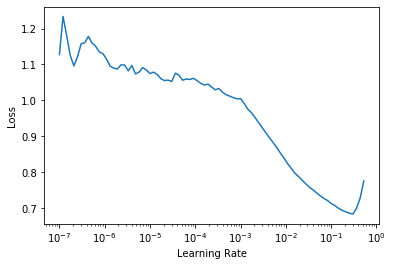

In [34]:
# learn.lr_find()

In [35]:
dbch = get_data(64, 384)
learn.dbunch = dbch

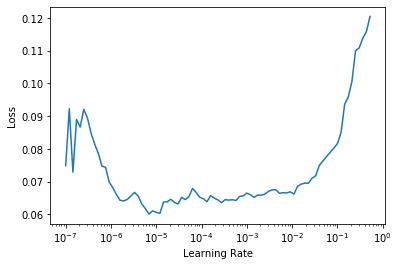

In [36]:
learn.lr_find()

In [ ]:
fit_tune3(64, 384, 1, 3e-4)
learn.save('dcm-384-bs64--ep4')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time


In [42]:
learn.recorder.values


[(#4) [0.06713367998600006,0.07727093249559402,0.9753143787384033,0.9521489143371582]]

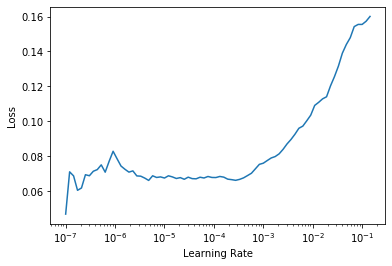

In [53]:
learn.lr_find()

Scale up to full size data

torch.Size([32, 3, 512, 512])

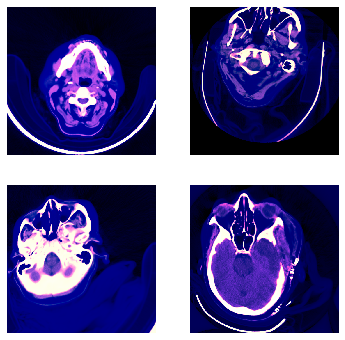

In [46]:
dbch = get_data(32,512)
x,y = to_cpu(dbch.one_batch())
dbch.show_batch(max_n=4)
x.shape

In [52]:
def get_learner_full():
    dbch = get_data(32,512)
    learn = cnn_learner(dbch, resnet101, loss_func=loss_func, opt_func=opt_func, metrics=metrics)
    return learn.to_fp16()

In [53]:
learn = get_learner_full()

In [54]:
learn.load('dcm-384-bs64--ep4')

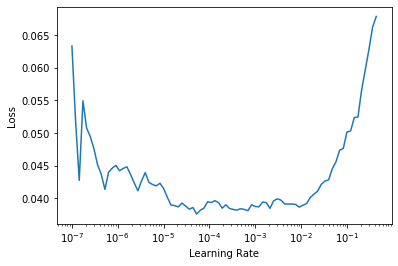

In [57]:
learn.lr_find()

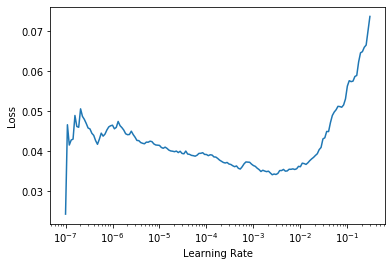

In [58]:
learn.lr_find(num_it=200)

In [60]:
learn.lr_find(num_it=500)

FileNotFoundError: [Errno 2] No such file or directory: 'models/_tmp.pth'

In [ ]:
learn.unfreeze
fit_tune3(32, 512, 1, 3e-4)
learn.save('dcm-512-bs32--ep1')

## Prepare for submission

Now we're ready to submit. We can use the handy `test_dl` function to get an inference `DataLoader` ready, then we can check it looks OK.

In [43]:
test_fns = [(path_tst/f'{filename(o)}.dcm').absolute() for o in df_tst.fname.values]
print(len(test_fns) * 6)

471270


In [44]:
dbch = get_data(32,512)
# dbch = get_data(64,384)

In [45]:
tst = test_dl(dbch, test_fns)
x = tst.one_batch()[0]
x.min(),x.max()

(tensor(-2.4000, device='cuda:0'), tensor(1.6000, device='cuda:0'))

We pass that to `get_preds` to get our predictions, and then clamp them just in case we have some extreme values.

In [46]:
preds,targs = learn.get_preds(dl=tst)
preds_clipped = preds.clamp(.00001, .9999)

I'm too lazy to write a function that creates a submission file, so this code is stolen from Radek, with minor changes.

In [47]:
ids = []
labels = []

for idx,pred in zip(df_tst.index, preds_clipped):
    for i,label in enumerate(htypes):
        ids.append(f"{idx}_{label}")
        predicted_probability = '{0:1.10f}'.format(pred[i].item())
        labels.append(predicted_probability)

In [48]:
df_csv = pd.DataFrame({'ID': ids, 'Label': labels})
df_csv.to_csv(f'submission.csv', index=False)
df_csv.head()

,ID,Label
0,ID_e3674b189_any,0.0003379794
1,ID_e3674b189_epidural,0.0001055469
2,ID_e3674b189_intraparenchymal,0.0000615676
3,ID_e3674b189_intraventricular,0.0000100000
4,ID_e3674b189_subarachnoid,0.0000748462


In [49]:
df_csv

,ID,Label
0,ID_e3674b189_any,0.0003379794
1,ID_e3674b189_epidural,0.0001055469
2,ID_e3674b189_intraparenchymal,0.0000615676
3,ID_e3674b189_intraventricular,0.0000100000
4,ID_e3674b189_subarachnoid,0.0000748462
...,...,...
471265,ID_7d121cd7c_epidural,0.0000551892
471266,ID_7d121cd7c_intraparenchymal,0.0001159193
471267,ID_7d121cd7c_intraventricular,0.0000100000
471268,ID_7d121cd7c_subarachnoid,0.0001283094


Run the code below if you want a link to download the submission file.

In [50]:
from IPython.display import FileLink, FileLinks
FileLink('submission.csv')

/home/tirrell_le/rsna-intracranial-hemorrhage-detection/notebooks/ltirrell/submission.csv

In [51]:
len(df_csv)

471270

In [52]:
len(preds)

78545